In [14]:
# Last mod: FA 2023 Jan 31 - first version

# Testing XGBoost ages with other catalogues

First, let's import some libraries:

In [145]:
import numpy as np #numpy
import pandas as pd
import matplotlib.pyplot as plt  #matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table  #astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, join
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde  #scipy: science python
import os.path

from time import time
from sklearn import manifold, datasets

from itertools import product
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Read asteroseismic age data tables

As an anchor for our method, we want asteroseismic ages for red giant stars. 
The most reliable ones are using Kepler + APOGEE data ([Miglio+2021](https://www.aanda.org/articles/aa/full_html/2021/01/aa38307-20/aa38307-20.html)):

In [19]:
miglio2021 = Table.read("../data/kepler_apogee_miglio2021.fit")
miglio2021

APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,b_Age,b_age_lc,Mass,b_Mass,b_mass_lc,Rad,b_Rad,b_rad_lc,Dist,b_Dist,b_dist_lc,Av,b_Av,b_av_lc,evstate,zmax,e_zmax,Ecc,e_Ecc,Rperi,e_Rperi,Rap,e_Rap,GalR,Galphi,GalZ,vR,vT,vZ,_RA,_DE
,,mag,mag,mag,deg,deg,,,Gyr,Gyr,Gyr,solMass,solMass,solMass,solRad,solRad,solRad,kpc,kpc,kpc,mag,mag,mag,,kpc,kpc,,,kpc,kpc,kpc,kpc,kpc,rad,kpc,km / s,km / s,km / s,deg,deg
bytes20,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2M19222920+3710285,1569842,9.589,9.074,8.989,290.6217,37.1746,-0.24,0.12,9.8,7.9,12.6,1.0,0.93,1.06,4.98,4.86,5.08,0.619,0.61,0.629,0.07,-0.01,0.14,1,0.366,0.006,0.112,0.002,6.648,0.019,8.328,0.005,7.933,0.072,0.131,-29.82,209.19,21.51,290.62167,37.17458
2M19300513+3717470,1726291,11.206,10.679,10.547,292.5214,37.2964,-0.34,0.19,10.1,8.0,12.8,0.98,0.92,1.05,4.68,4.56,4.76,1.17,1.152,1.188,0.43,0.35,0.49,1,0.31,0.004,0.168,0.001,7.417,0.014,10.42,0.012,7.812,0.14,0.204,31.83,245.94,10.69,292.52137,37.29639
2M19045380+3741230,2283721,11.266,10.709,10.59,286.2242,37.6897,-0.19,0.11,9.4,7.5,12.0,1.01,0.96,1.09,6.58,6.41,6.7,1.676,1.65,1.701,0.3,0.2,0.35,1,0.493,0.008,0.072,0.001,6.745,0.011,7.798,0.01,7.68,0.198,0.415,-16.38,210.65,-16.16,286.22417,37.68972
2M19060736+3740100,2284679,9.923,9.456,9.335,286.5307,37.6694,-0.45,0.21,11.2,9.0,14.0,0.94,0.89,1.0,3.98,3.89,4.06,0.588,0.58,0.597,0.07,0.0,0.13,1,0.821,0.004,0.844,0.0,0.692,0.003,8.204,0.004,7.934,0.067,0.157,66.53,37.45,-39.19,286.53067,37.66944
2M19280882+3736381,2305590,9.829,9.235,9.128,292.0368,37.6106,-0.3,0.24,10.2,8.3,12.4,1.03,0.95,1.07,8.43,8.28,8.63,1.072,1.059,1.085,0.34,0.28,0.38,1,0.529,0.014,0.587,0.002,2.392,0.006,9.188,0.026,7.835,0.128,0.197,111.85,114.69,27.8,292.03675,37.61058
2M19250117+3742537,2442483,11.509,10.934,10.812,291.2549,37.7149,-0.14,0.12,10.0,7.9,12.7,1.02,0.95,1.08,5.87,5.73,6.0,1.662,1.636,1.688,0.37,0.29,0.45,1,0.338,0.006,0.208,0.002,5.329,0.017,8.135,0.008,7.726,0.201,0.312,43.73,189.59,7.28,291.25487,37.71492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2M19133250+5140282,12598909,11.342,10.776,10.617,288.3854,51.6745,0.16,0.0,11.0,9.7,13.4,1.02,0.97,1.07,7.86,7.7,7.98,1.998,1.975,2.022,0.13,0.09,0.2,1,0.689,0.009,0.202,0.001,5.854,0.009,8.824,0.026,8.1,0.236,0.629,-49.3,194.57,-9.92,288.38542,51.6745


We also have the K2 + GALAH data from [Zinn+2020](https://ui.adsabs.harvard.edu/abs/2020ApJS..251...23Z/abstract):

In [31]:
zinn2020 = Table.read("../data/k2_galah_zinn2020.fits")
zinn2020

EPIC,GALAH,age,e_age,FeH,Teff,MgFe,e_FeH,e_Teff,e_MgFe,sobject_id_1,EDR3_source_id,glon,glat,age05,age16,age50,age84,age95,ageflag,mass16,mass50,mass84,teff16,teff50,teff84,met16,met50,met84,logg16,logg50,logg84,dist05,dist16,dist50,dist84,dist95,AV05,AV16,AV50,AV84,AV95,Xg,Yg,Zg,Rg
int32,int64,float32,float32,float32,int16,float64,float32,int16,float32,int64,bytes100,float32,float32,float32,float32,float32,float32,float32,bytes20,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
220387110,161007003801220,7.7,1.8,-0.18,4691,0.15,0.063,91,0.058,161007003801220,2554396309982001536,116.22801,-58.23026,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.99546677,1.069267,1.2121592,4675.4263,4717.3604,4773.294,-0.19519514,-0.09886605,-0.046779405,2.7061815,2.7450333,2.8056407,0.7124427,0.72190547,0.73900783,0.75657296,0.76765734,-0.1677314,-0.06465694,0.09331309,0.25045037,0.3419845,-8.37195737063698,0.349032658183932,-0.6282829298350185,8.379229917614255
220352927,161007003801158,11.0,1.5,-1.3,4883,0.12,0.11,124,0.12,161007003801158,2553749453547532800,116.2454,-58.934113,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.8113137,0.8462425,0.8778329,4838.175,4879.245,4927.825,-1.2285982,-1.0858957,-0.9742354,2.0896122,2.1566837,2.2354307,1.9977691,2.1256893,2.311502,2.490357,2.6338108,-0.19244775,-0.08978152,0.06709295,0.22286183,0.3285024,-8.727471271577219,1.0698224713058024,-1.9799735706059487,8.792796763050795
220420379,161007003801285,5.2,2.9,-0.6,4705,0.32,0.12,136,0.18,161007003801285,2554552848654332928,117.28564,-57.62667,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.8686563,0.9120761,0.96866316,4681.9077,4754.0786,4901.924,-0.5495246,-0.40926585,-0.26454726,2.328565,2.378746,2.4247105,1.5853473,1.6588559,1.7346382,1.8376716,1.9271879,-0.16861773,-0.061954595,0.10427424,0.27371448,0.38141242,-8.625779351635325,0.825440025173661,-1.465035986731263,8.665184398398976
220329169,161007003801110,4.1,0.74,-0.3,4864,0.12,0.066,95,0.064,161007003801110,2550699786248593792,116.9833,-59.47032,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.95956415,1.0154893,1.1299838,4813.4883,4855.1836,4904.427,-0.29618782,-0.202951,-0.14829238,2.9305604,2.9688995,3.018476,0.6020639,0.61126274,0.62707615,0.6428746,0.6533361,-0.100228734,0.011356348,0.1713531,0.3237294,0.42670974,-8.344533680982613,0.2838678413935867,-0.5401421667601018,8.349360652435053
220425435,161007003801301,9.2,2.7,-1.6,5060,0.11,0.2,174,0.18,161007003801301,2554566906082928896,117.715546,-57.549053,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.79715335,0.8347923,0.8737508,4936.77,5016.359,5094.402,-1.4338722,-1.1897494,-0.9390785,2.2937765,2.351029,2.4067307,1.9291867,1.9917191,2.102193,2.22872,2.3186636,-0.21051358,-0.10805751,0.0471158,0.20430382,0.30969068,-8.724607768204562,0.9985721580317268,-1.7739380588118978,8.781567460528418
220377647,161007003801390,4.2,0.85,-0.4,4995,0.16,0.092,116,0.12,161007003801390,2554156169770546176,118.1675,-58.51864,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.93497425,1.001721,1.170043,4921.083,4974.993,5036.442,-0.40414768,-0.30602524,-0.20757318,3.0901895,3.138089,3.207226,0.764847,0.78239816,0.8098667,0.838986,0.8606932,-0.20250176,-0.101588465,0.05503788,0.21163452,0.3161291,-8.399644247350842,0.3728425639274693,-0.6906625163935549,8.407915024518868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246294910,161106002101303,8.7,2.3,-0.37,4569,0.25,0.07,92,0.073,161106002101303,2447407128450796032,89.771164,-62.16215,-999.0,-999.0,-999.0,-999.0,-999.0,no ages,0.94316685,0.97760683,1.0276247,4574.388,4607.221,4643.975,-0.29230693,-0.20248318,-0.14781968,2.3881285,2.433921,2.4755273,1.6718314,1.7126739,1.7886218,1.8769522,1.9398276,0.06369984,0.113173395,0.18319097,0.2

The TESS CVZ analysis of [Mackereth+2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.1947M/abstract):

In [25]:
mackereth2021 = Table.read("../data/tess_cvz_mackereth2021.fits")
mackereth2021

source_id,TIC,N_sectors,ra,ra_error,dec,dec_error,l,b,ecl_lon,ecl_lat,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,hmag,jmag,kmag,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,A_K,numax_COR,numax_err_COR,dnu_COR,dnu_err_COR,numax_BHM,numax_err_BHM,dnu_BHM,dnu_err_BHM,numax_A2Z,numax_err_A2Z,dnu_A2Z,dnu_err_A2Z,mean_numax,mean_numax_err,mean_dnu,mean_dnu_err,N_pipelines_mean,seismic_param_gold,logg_HERMES,e_logg_HERMES,Teff_SKYMAPPER,e_Teff_SKYMAPPER,feh_SKYMAPPER,e_feh_SKYMAPPER,ecc_MB2018,ecc_err_MB2018,rperi_MB2018,rperi_err_MB2018,rap_MB2018,rap_err_MB2018,zmax_MB2018,zmax_err_MB2018,APOGEE_ID_APOGEE,FE_H_APOGEE,FE_H_ERR_APOGEE,MG_FE_APOGEE,MG_FE_ERR_APOGEE,LOGG_APOGEE,LOGG_ERR_APOGEE,TEFF_APOGEE,TEFF_ERR_APOGEE,age_PARAM_BHM,age_68L_PARAM_BHM,age_68U_PARAM_BHM,mass_PARAM_BHM,mass_68L_PARAM_BHM,mass_68U_PARAM_BHM,rad_PARAM_BHM,rad_68L_PARAM_BHM,rad_68U_PARAM_BHM,CHI2_gof_PARAM_BHM,mbol_PARAM_BHM_NO_L,mbol_68L_PARAM_BHM_NO_L,mbol_68U_PARAM_BHM_NO_L,age_APO_PARAM_BHM,age_68L_APO_PARAM_BHM,age_68U_APO_PARAM_BHM,mass_APO_PARAM_BHM,mass_68L_APO_PARAM_BHM,mass_68U_APO_PARAM_BHM,rad_APO_PARAM_BHM,rad_68L_APO_PARAM_BHM,rad_68U_APO_PARAM_BHM,CHI2_gof_APO_PARAM_BHM,luminosity_BHM,luminosity_68U_BHM,luminosity_68L_BHM,luminosity_COR,luminosity_68U_COR,luminosity_68L_COR,luminosity_A2Z,luminosity_68U_A2Z,luminosity_68L_A2Z,luminosity_HERMES,luminosity_68L_HERMES,luminosity_68U_HERMES,luminosity_GAIA,luminosity_68L_GAIA,luminosity_68U_GAIA,luminosity_APO_GAIA,luminosity_68L_APO_GAIA,luminosity_68U_APO_GAIA,evstate_MV,evstate_agreement_MV,lum_flag_BHM,lum_flag_COR,lum_flag_A2Z,numax_dnu_consistent,numax_predicted,numax_predicted_err,XGal,YGal,RGal,ZGal
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,kpc,kpc
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,int64,bool,float64,float64,int16,int16,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,bytes18,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
4759266867156545536,149346975,12,83.60831823704378,0.016513296871897606,-61.367357156985165,0.020950273018090767,270.39488656131465,-32.740472162313885,58.713340274750834,-84.10404629877485,0.8345997958314426,0.01842033445434786,2.163634672996713,0.0368518784184908,-2.690981911278145,0.04079146622034934,4.73603117169421,2.5378549005334428,0.0017837603,0.14757405,-0.08866062,0.0038818587,0.24734992,0.070875384,-0.42472336,0.06461448,-0.24970464,-0.084684856,7.799,8.461,7.562,10.39577,11.151597,9.583019,0.019277696641225295,95.59,1.78,8.782,0.02,7.14,0.85,1.25991,0.172391,7.8,0.31,-999.0,-999.0,36.843334,1.9967474,5.020955,0.17354728,3,False,-9999.0,-9999.0,4212,113,0.035,0.157,0.20002664444158158,0.005680813014159833,7.224120866889526,0.050201324655128055,10.827794879270597,0.1834015217838827,0.8620629465213455,0.034179216542717494,--,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,16.046504,12.549988,18.597925,0.895296,0.851009,0.96

The CoRoT + APOGEE data from [Anders+2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A..30A/abstract):

In [20]:
anders2017 = Table.read("../data/corot_apogee_anders2017.fit")
anders2017

CoRoT,APOGEE,RAJ2000,DEJ2000,GLON,GLAT,FIELD,run,Seismic,numax,e_numax,Dnu,e_Dnu,evstat,ASPCAP,File,Tel,Loc,TargFlags,NVisits,SNR,StarFlags,__RV_,sigma,e__RV_,Teff,e_Teff,logg,e_logg,__M_H_,__M_H_A,e__M_H_,__alpha_M_,e__alpha_M_,chi2,ASPCAPFlags,__Al_H_,__Ca_H_,__C_H_,__Fe_H_,__K_H_,__Mg_H_,__Mn_H_,__Na_H_,__Ni_H_,__N_H_,__O_H_,__Si_H_,__S_H_,__Ti_H_,__V_H_,e__Al_H_,e__Ca_H_,e__C_H_,e__Fe_H_,e__K_H_,e__Mg_H_,e__Mn_H_,e__Na_H_,e__Ni_H_,e__N_H_,e__O_H_,e__Si_H_,e__S_H_,e__Ti_H_,e__V_H_,f__Al_H_,f__Ca_H_,f__C_H_,f__Fe_H_,f__K_H_,f__Mg_H_,f__Mn_H_,f__Na_H_,f__Ni_H_,f__N_H_,f__O_H_,f__Si_H_,f__S_H_,f__Ti_H_,f__V_H_,EKs,MetEKs,SFDE_B-V_,RCDist,Visits,BmagO,e_BmagO,VmagO,e_VmagO,RmagO,e_RmagO,ImagO,e_ImagO,AllWISE,Jmag,e_Jmag,Hmag,e_Hmag,Ksmag,e_Ksmag,W1mag,e_W1mag,W2mag,e_W2mag,W3mag,e_W3mag,W4mag,e_W4mag,BmagA,e_BmagA,VmagA,e_VmagA,gmagA,e_gmagA,rmagA,e_rmagA,imagA,e_imagA,RAEdeg,DEEdeg,CCD,WIN,x,y,SpType,LC,Tcol,PPMXL,USNOB1,_2MASS,USNOA2,CMC14,TYCHO2,UCAC2,UCAC4,pmRA,e_pmRA,pmDE,e_pmDE,UCAC4flag,MassS,loggS,RadiusS,AgeM,AgeM68L,AgeM68U,AgeM95L,AgeM95U,eAgeI,eAgee,eAgeT,MassM,MassM68L,MassM68U,MassM95L,MassM95U,RadiusM,RadiusM68L,RadiusM68U,RadiusM95L,RadiusM95U,loggM,loggM68L,loggM68U,loggM95L,loggM95U,DistM,DistM68L,DistM68U,DistM95L,DistM95U,AVM,AVM68L,AVM68U,AVM95L,AVM95U,nfilt,filt,Xg,e_Xg,Yg,e_Yg,Zg,e_Zg,Rg,e_Rg,vT,e_vT,vXg,e_vXg,vYg,e_vYg,vZg,e_vZg,vRg,e_vRg,vPhig,e_vPhig,Rguide,e_Rguide,Simbad
,,deg,deg,deg,deg,,,,muHz,muHz,muHz,muHz,,,,,,,,,,km / s,km / s,km / s,K,K,log(cm.s**-2),log(cm.s**-2),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,,mag,kpc,,mag,mag,mag,mag,mag,mag,mag,mag,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,deg,deg,,,,,,,K,,,,,,,,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,Gyr,solMass,solMass,solMass,solMass,solMass,solRad,solRad,solRad,solRad,solRad,log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),log(cm.s**-2),pc,pc,pc,pc,pc,mag,mag,mag,mag,mag,,,kpc,kpc,kpc,kpc,kpc,kpc,kpc,kpc,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,kpc,kpc,
int32,bytes18,float64,float64,float64,float64,bytes7,bytes5,bytes14,float64,float64,float64,float64,bytes5,bytes44,bytes33,bytes6,int16,bytes59,int16,float64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes31,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,int16,float64,bytes17,float64,float64,bytes125,float64,float64,float64,float64,float64,float64,float64,float64,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes2,int16,float64,float64,bytes2,bytes3,int16,bytes19,bytes12,bytes16,bytes13,bytes15,int32,int32,bytes10,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,bytes26,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7
100448189,2M19223319+0141341,290.638327,1.692813,38.00855,-6.13865,COROTC,LRc01,automatic fit,16.93,0.624,2.27,0.035,,apogee.apo25m.s.v603.4398.2M19223319+0141341,apStar-r5-2M19223319+0141341.fits,apo25m,4398,"APOGEE_ANCILLARY,APOGEE_DISK_RED_GIANT",3,261.212,,90.061699,0.036332,0.014074,4492.8687,91.466736,2.20127,

In [21]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Dec2022.fits")
chem_age = np.isfinite(dr17_master['Chemical_Age_Dec2022'])

## Location in the Galaxy (RGal vs ZGal, XGal vs YGal)

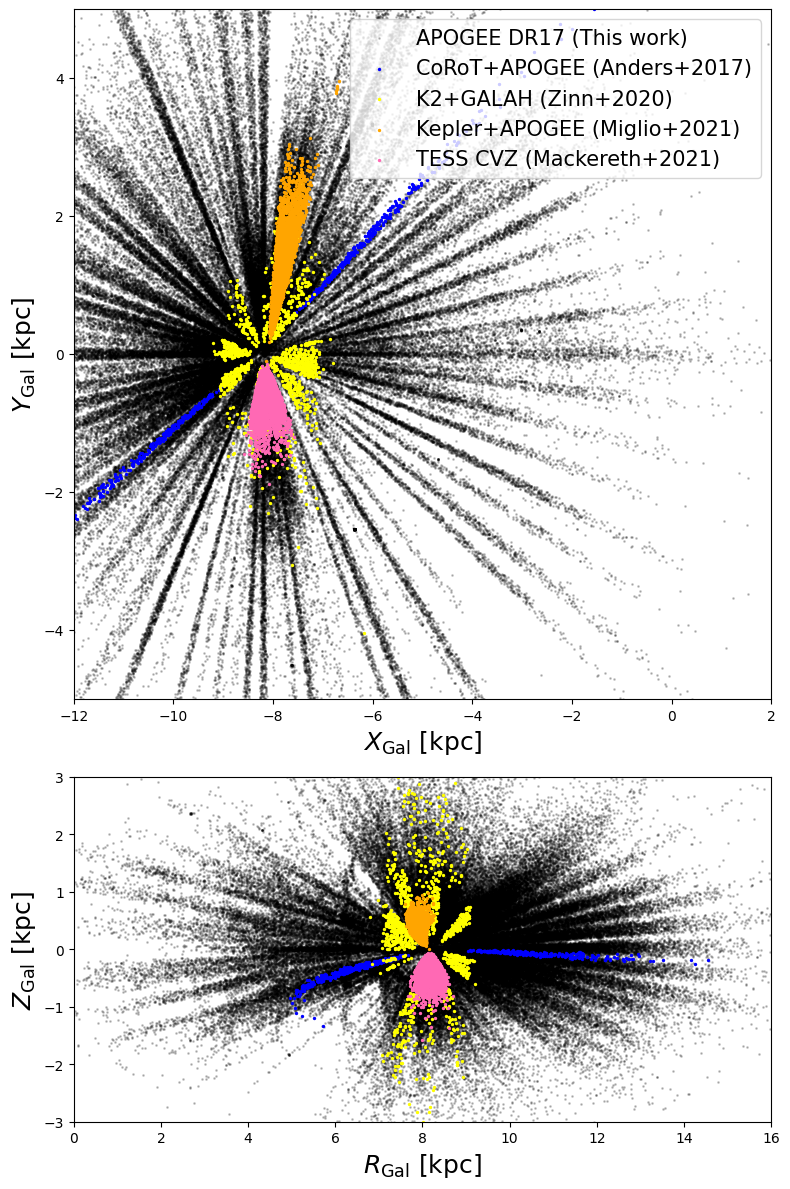

In [52]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[4, 2], figsize=(8,12))

a0.scatter(-dr17_master['Xg'][chem_age], dr17_master['Yg'][chem_age], c="k", s=1, alpha=0.2, label="APOGEE DR17 (This work)")
a0.scatter(-anders2017['Xg'],   anders2017['Yg'],   s=2, c="b", label="CoRoT+APOGEE (Anders+2017)")
a0.scatter(zinn2020['Xg'],     zinn2020['Yg'],     s=2, c="yellow", label="K2+GALAH (Zinn+2020)")
a0.scatter(-np.cos(miglio2021['Galphi'])*(miglio2021['GalR']), 
           np.sin(miglio2021['Galphi'])*(miglio2021['GalR']),
           s=2, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a0.scatter(mackereth2021['XGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['YGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a0.axis([-12, 2, -5, 5])
a0.set_xlabel(r"$X_{\rm Gal}$ [kpc]", fontsize=18)
a0.set_ylabel(r"$Y_{\rm Gal}$ [kpc]", fontsize=18)
a0.legend(loc="upper right", fontsize=15)

a1.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=0.2, label="APOGEE DR17 (This work)")
a1.scatter(anders2017['Rg'],   anders2017['Zg'],   s=2, c="b", label="CoRoT+APOGEE (Anders+2017)")
a1.scatter(zinn2020['Rg'],     zinn2020['Zg'],     s=2, c="yellow", label="K2+GALAH (Zinn+2020)")
a1.scatter(miglio2021['GalR'], miglio2021['GalZ'], s=2, c="orange", label="Kepler+APOGEE (Miglio+2021)")
a1.scatter(mackereth2021['RGal'][mackereth2021["age_PARAM_BHM"]>0], 
            mackereth2021['ZGal'][mackereth2021["age_PARAM_BHM"]>0], 
            s=2, c="hotpink", label="TESS CVZ (Mackereth+2021)")
a1.axis([0, 16, -3, 3])
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/XYRZ_all_vs_others.png")

## Age uncertainty as a function of age

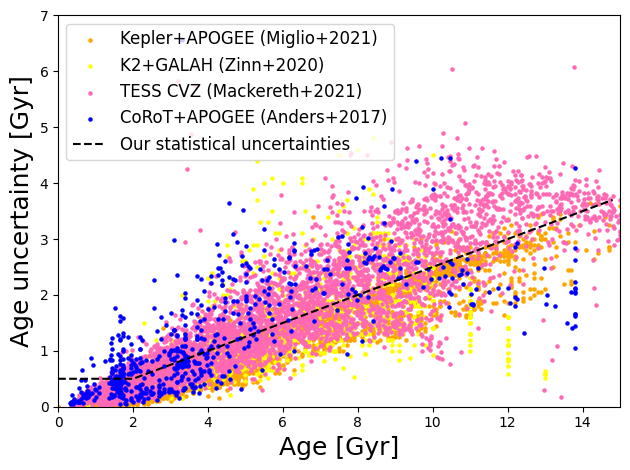

In [177]:
#Ages
plt.scatter(miglio2021['Age'], 0.5*(miglio2021['b_age_lc']-miglio2021['b_Age']), 
            c="orange", label="Kepler+APOGEE (Miglio+2021)", s=5)
plt.scatter(zinn2020['age'], zinn2020['e_age'],
            c="yellow", label="K2+GALAH (Zinn+2020)", s=5)
plt.scatter(mackereth2021['age_PARAM_BHM'][mackereth2021['age_PARAM_BHM']>0],
            0.5*(mackereth2021['age_68U_PARAM_BHM']-mackereth2021['age_68L_PARAM_BHM'])[mackereth2021['age_PARAM_BHM']>0],
            c="hotpink", label="TESS CVZ (Mackereth+2021)", s=5)
plt.scatter(anders2017['AgeM'], 0.5*(anders2017['AgeM68U']-anders2017['AgeM68L']),
            c="b", label="CoRoT+APOGEE (Anders+2017)", s=5)
#plt.title('Statistical age uncertainty vs. age')
plt.plot(np.arange(0,15,0.2),np.maximum(0.25*np.arange(0,15,0.2), 0.5),'k--', label=r"Our statistical uncertainties")
plt.legend(loc="upper left", fontsize=12)
plt.axis([0,15,0,7])
plt.xlabel('Age [Gyr]', fontsize=18)
plt.ylabel(r"Age uncertainty [Gyr]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/seismic_age_uncerts.png")

## Crossmatch each of those catalogues with our "chemical ages"

In [96]:
# Our coordinates
our_cat = dr17_master[ chem_age & (dr17_master["RA"]>0.) ]

our_coords  = SkyCoord(our_cat['RA'], our_cat['DEC'], 
                       unit=(u.deg, u.deg), frame="icrs")

In [97]:
# Zinn+2020 - filter before matching
zinn2020    = zinn2020[zinn2020['glon']>0.]
zinn_coords = SkyCoord(zinn2020['glon'], zinn2020['glat'], 
                       unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_z, sep_z, _ = zinn_coords.match_to_catalog_sky(our_coords)

# Mackereth+2021 - filter before matching
mackereth2021 = mackereth2021[mackereth2021['age_PARAM_BHM']>0]
mack_coords   = SkyCoord(mackereth2021['l'], mackereth2021['b'], 
                         unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_m, sep_m, _ = mack_coords.match_to_catalog_sky(our_coords)

# Anders+2017
anders_coords = SkyCoord(anders2017['GLON'], anders2017['GLAT'], 
                         unit=(u.deg, u.deg), frame="galactic")
# idx_z = the indices into our_coords that get the closest matches in zinn_coords
idx_a, sep_a, _ = anders_coords.match_to_catalog_sky(our_coords)

## Produce a comparison plot:

In [115]:
from scipy.interpolate import make_interp_spline

def mdline(x,y,bins):
    xmin = np.min(x)
    xmax = np.max(x)
    r = (xmax-xmin)/bins
    liney50=np.zeros(bins)
    liney84=np.zeros(bins)
    liney16=np.zeros(bins)
    linex=np.zeros(bins)
    for i in range(0,bins):
        if (len(y[(x>(xmin+r*i))&(x<(xmin+r*i+r))])> 0.0):
            liney50[i] = np.percentile((y[(x>(xmin+r*i))&(x<(xmin+r*i+r))]),50)
            liney84[i] = np.percentile((y[(x>(xmin+r*i))&(x<(xmin+r*i+r))]),84)
            liney16[i] = np.percentile((y[(x>(xmin+r*i))&(x<(xmin+r*i+r))]),16)
            linex[i]= xmin+r*i+ 0.5*r
        else:
            liney50[i] = np.nan
            liney84[i] = np.nan
            liney16[i] = np.nan
            linex[i]= np.nan
    linex,liney50,liney84,liney16 = linex[~np.isnan(linex)],liney50[~np.isnan(liney50)],liney84[~np.isnan(linex)],liney16[~np.isnan(linex)]
    return linex,liney50,liney84,liney16

def overplot_trend(X, Y, alpha=0.2, color="k", bins=10):
    lines = mdline(X, Y, bins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=3)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=3)
    plt.fill_between(lines[0], lines[3], lines[2], alpha=alpha, color=color)


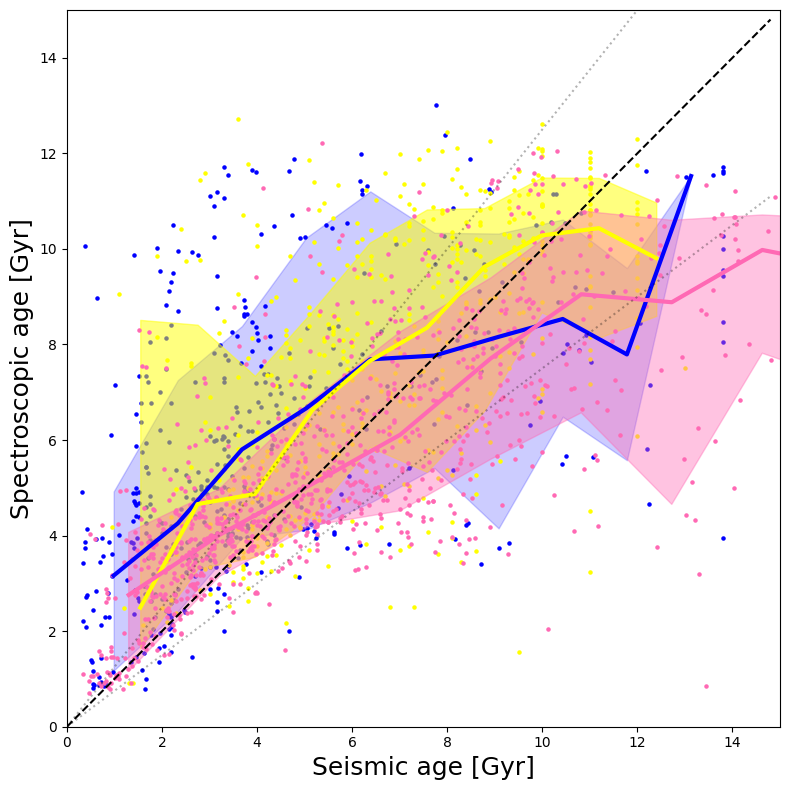

In [179]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

# Anders+2017 - Only plot the matches with sep < 1 arcsec!
plt.scatter(anders2017['AgeM'][sep_a.arcsec<1], 
            our_cat["Chemical_Age_Dec2022"][idx_a][sep_a.arcsec<1],
            #xerr=[anders2017['AgeM'][sep_a.arcsec<1]-anders2017['AgeM68L'][sep_a.arcsec<1], 
            #      anders2017['AgeM68U'][sep_a.arcsec<1]-anders2017['AgeM'][sep_a.arcsec<1]],
            #yerr=0.25*our_cat["Chemical_Age_Dec2022"][idx_a][sep_a.arcsec<1],
            c="b", label="CoRoT+APOGEE (Anders+2017)", s=5)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(anders2017['AgeM'][sep_a.arcsec<1],
               our_cat["Chemical_Age_Dec2022"][idx_a][sep_a.arcsec<1], 
               alpha=0.2, color="b", bins=10)

# Zinn+2020 - Only plot the matches with sep < 1 arcsec!
plt.scatter(zinn2020['age'][sep_z.arcsec<1], 
            our_cat["Chemical_Age_Dec2022"][idx_z][sep_z.arcsec<1],
            c="yellow", label="K2+GALAH (Zinn+2020)", s=5)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(zinn2020['age'][sep_z.arcsec<1],
               our_cat["Chemical_Age_Dec2022"][idx_z][sep_z.arcsec<1],
               bins=10, alpha=0.5, color='yellow')

# Mackereth+2021 - Only plot the matches with sep < 1 arcsec!
plt.scatter(mackereth2021['age_PARAM_BHM'][sep_m.arcsec<1], 
            our_cat["Chemical_Age_Dec2022"][idx_m][sep_m.arcsec<1],
            c="hotpink", label="TESS CVZ (Mackereth+2021)", s=5)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(mackereth2021['age_PARAM_BHM'][sep_m.arcsec<1],
               our_cat["Chemical_Age_Dec2022"][idx_m][sep_m.arcsec<1],
               bins=10, alpha=0.4, color='hotpink')

plt.plot(np.arange(0,15,0.2),np.arange(0,15,0.2),'k--')
plt.plot(np.arange(0,15,0.2),0.75*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.plot(np.arange(0,15,0.2),1.25*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)

#plt.legend(loc="upper left", fontsize=15)
plt.axis([0,15,0,15])
plt.xlabel('Seismic age [Gyr]', fontsize=18)
plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/seismic_age_comp.png")

## Cantat-Gaudin+2020 open clusters

In [146]:
# Read Cantat+2020 tables
cg1 = Table.read("../data/CG2020.fit")
cg2 = Table.read("../data/CG2020members.fit")
# Join them
cg = join(cg2, cg1, keys="Cluster", join_type="left")
cg['GaiaDR2'].name = 'source_id'
cg = cg[cg["proba"] > 0.95] # only select >95% Pmemb

In [151]:
# Xmatch CG+2020 with our APOGEE cat
our_cat["source_id"] = our_cat["GaiaEDR3_sourceID"]
matched = join(our_cat[our_cat["source_id"]>0], cg, keys="source_id", join_type="inner")

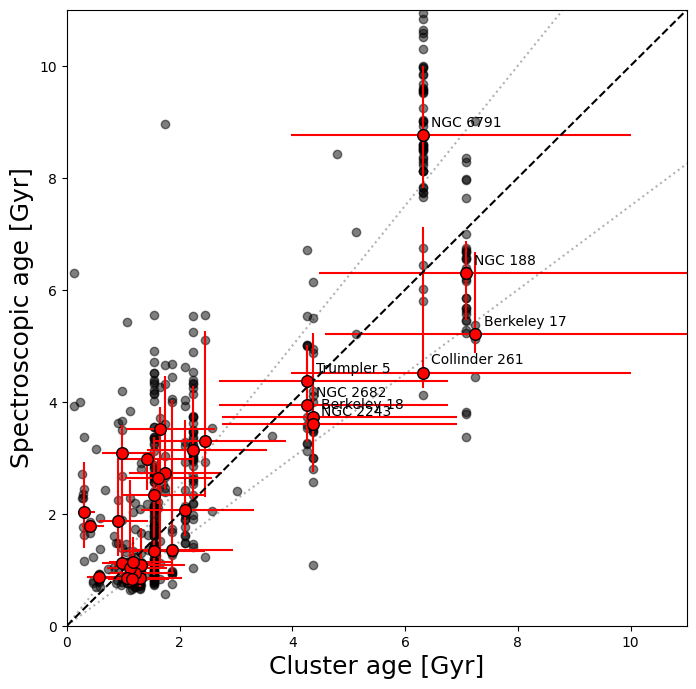

In [175]:
f, (ax) = plt.subplots(1, 1, figsize=(8,8))
# Individual stars
plt.scatter(10.**(matched["AgeNN"]-9), matched["Chemical_Age_Dec2022"], 
            c="k", alpha=0.5)
# Cluster averages
clusters = np.unique(matched["Cluster"])
for cc in clusters:
    if np.sum(matched["Cluster"]==cc) < 3:
        pass
    else:
        # Compute and plot median ages
        c = matched[ matched["Cluster"]==cc ]
        #print(cc, len(c))
        plt.errorbar(10.**(c["AgeNN"][0]-9), np.median(c["Chemical_Age_Dec2022"]), 
                     xerr=[[10.**(c["AgeNN"][0]-9)-10.**(c["AgeNN"][0]-9-0.2)], 
                           [10.**(c["AgeNN"][0]-9+0.2)-10.**(c["AgeNN"][0]-9)]], 
                     yerr=[ [np.median(c["Chemical_Age_Dec2022"])- np.percentile(c["Chemical_Age_Dec2022"], 16)], 
                            [-np.median(c["Chemical_Age_Dec2022"])+ np.percentile(c["Chemical_Age_Dec2022"], 84)]],
                     c="r", ms=20, mec="k")
        plt.scatter(10.**(c["AgeNN"][0]-9), np.median(c["Chemical_Age_Dec2022"]), 
                    alpha=1,c="r", s=70, zorder=5, ec="k")
        if 10.**(c["AgeNN"][0]-9) > 2.5:
            ax.text(10.**(c["AgeNN"][0]-9)+.15,
                    np.percentile(c["Chemical_Age_Dec2022"], 50)+.15,
                    cc.replace("_", " "), zorder=6)
plt.axis([0,11,0,11])
plt.plot(np.arange(0,15,0.2),np.arange(0,15,0.2),'k--')
plt.plot(np.arange(0,15,0.2),0.75*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.plot(np.arange(0,15,0.2),1.25*np.arange(0,15,0.2),c='k', ls="dotted", alpha=0.3)
plt.xlabel('Cluster age [Gyr]', fontsize=18)
plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/cluster_age_comp.png")

## Comparison to StarHorse ages (Queiroz+2023)

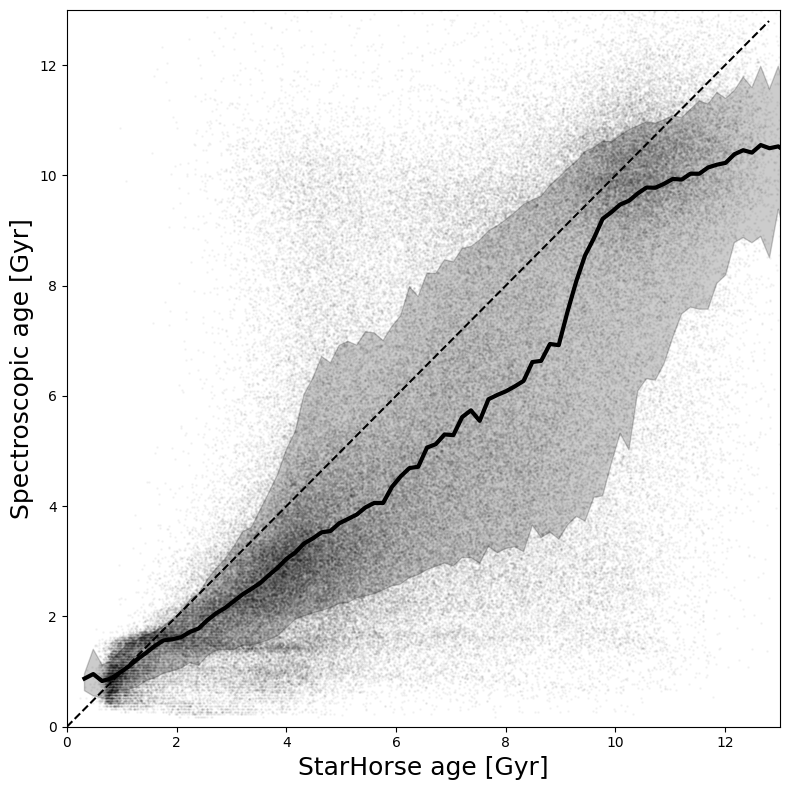

In [184]:
f, (a0) = plt.subplots(1, 1, figsize=(8,8))

# Anders+2017 - Only plot the matches with sep < 1 arcsec!
plt.scatter(our_cat["Chemical_Age_Dec2022"], our_cat["age50"],
            c="k", label="CoRoT+APOGEE (Anders+2017)", s=1, alpha=0.03)
# Overplot the trends (as in Queiroz+2023)
overplot_trend(our_cat["Chemical_Age_Dec2022"], our_cat["age50"], 
               alpha=0.2, color="k", bins=100)

plt.plot(np.arange(0,13,0.2),np.arange(0,13,0.2),'k--')

#plt.legend(loc="upper left", fontsize=15)
plt.axis([0,13,0,13])
plt.xlabel(r"StarHorse age [Gyr]", fontsize=18)
plt.ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/starhorse_age_comp.png")